In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [2]:
np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [3]:
skin_df = pd.read_csv('E:\__Thesis___\Skin Cancer\HAM10000_metadata.csv')
skin_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
SIZE=32

In [5]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [7]:
print(skin_df['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [8]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [9]:
skin_df.isna().isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [15]:
skin_df.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0001863,ISIC_0026272,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


C:\Users\PC\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


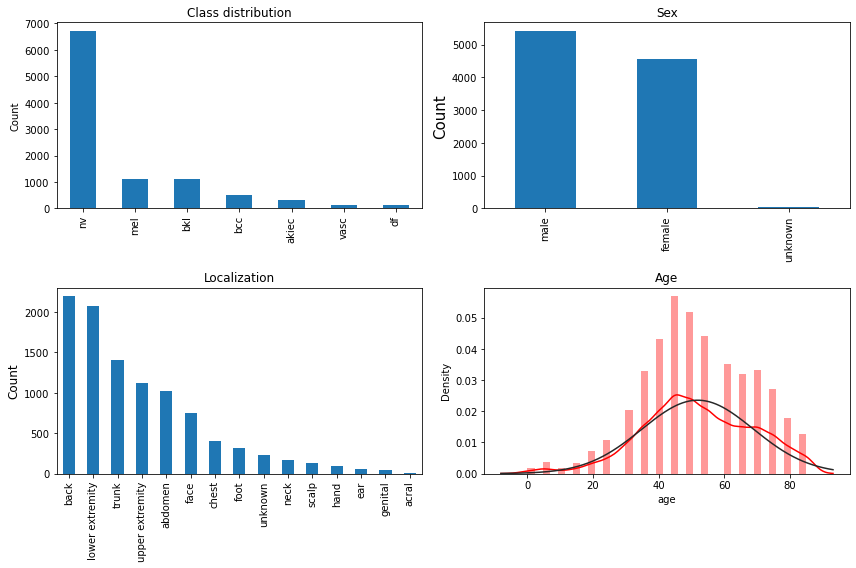

In [41]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Class distribution');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

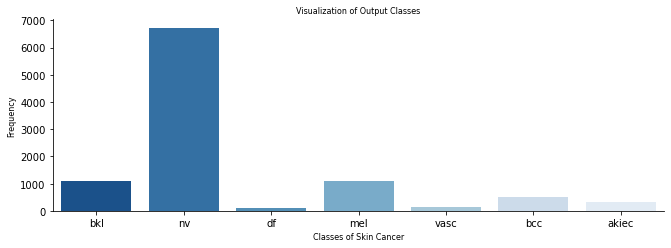

In [38]:
# We need to predict the cancer type, let's check the distribution of the values
g = sns.catplot(x="dx", kind="count", palette='Blues_r', data=skin_df)
g.fig.set_size_inches(10, 3)

g.ax.set_title('Visualization of Output Classes', fontsize=8)
g.set_xlabels('Classes of Skin Cancer', fontsize=8)
g.set_ylabels('Frequency', fontsize=8)

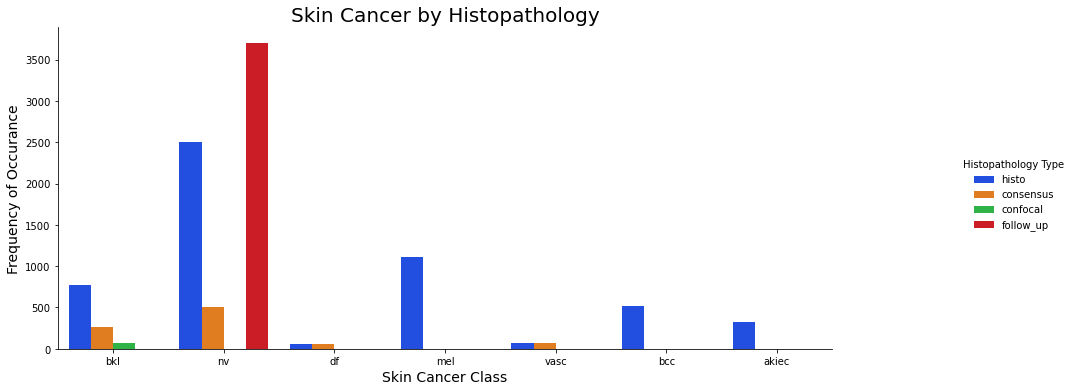

In [40]:
#Skin Cancer is confirmed via Hispathology, let's check the breakdown for each type
g = sns.catplot(x="dx", kind="count", hue="dx_type", palette='bright', data=skin_df)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Histopathology', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Histopathology Type')

In [45]:
print(skin_df['localization'].value_counts())

back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64


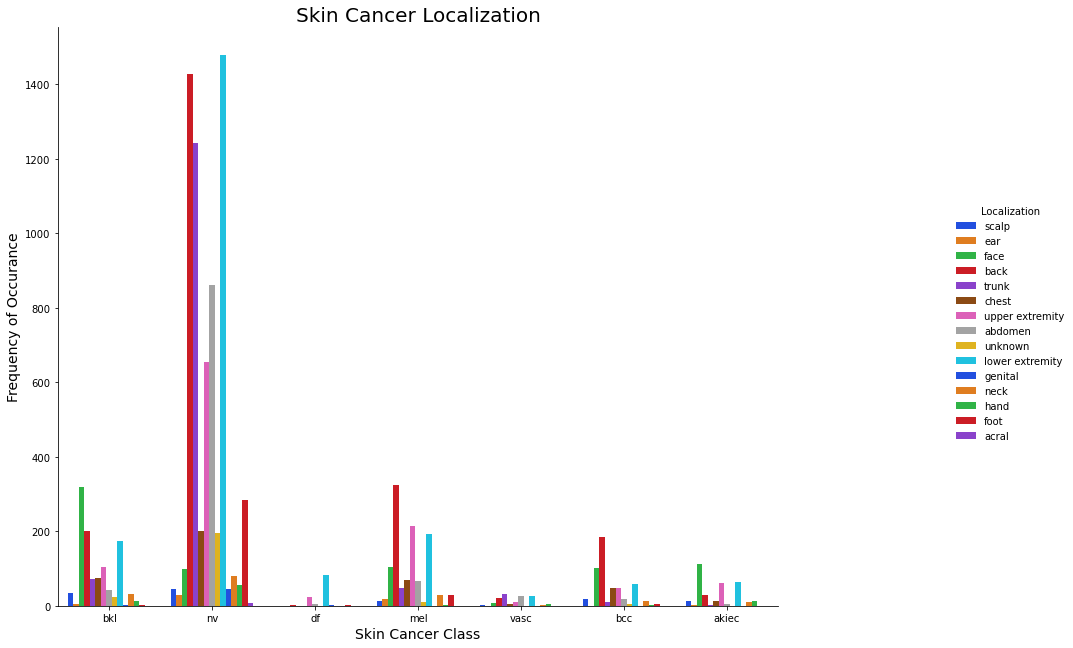

In [51]:
# Skin Cancer occurence body localization

g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=skin_df)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')

In [62]:
skin_df.groupby(['localization'])['dx'].value_counts()

localization     dx   
abdomen          nv       860
                 mel       66
                 bkl       42
                 vasc      27
                 bcc       18
                         ... 
upper extremity  bkl      104
                 akiec     62
                 bcc       49
                 df        24
                 vasc      11
Name: dx, Length: 81, dtype: int64

In [63]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(5))

        lesion_id      image_id   dx    dx_type   age     sex  \
6908  HAM_0005859  ISIC_0030829   nv      histo  35.0  female   
337   HAM_0007621  ISIC_0024626  bkl      histo  70.0    male   
6425  HAM_0005739  ISIC_0029763   nv  follow_up  35.0    male   
3810  HAM_0002262  ISIC_0027307   nv  follow_up  50.0  female   
82    HAM_0001773  ISIC_0024832  bkl      histo  40.0  female   

         localization  label  
6908            trunk      5  
337              back      2  
6425  lower extremity      5  
3810          abdomen      5  
82               face      2  


# Trainable CSV

In [66]:
df=pd.read_csv('E:\__Thesis___\Skin Cancer\hmnist_28_28_RGB.csv')
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [70]:
df.columns.value_counts()

pixel1142    1
pixel1559    1
pixel0968    1
pixel0209    1
pixel0004    1
            ..
pixel1584    1
pixel0484    1
pixel1151    1
pixel1679    1
pixel0077    1
Length: 2353, dtype: int64

In [71]:
x=df.drop('label',axis=1)
y=df['label']
x=x.to_numpy()
x=x/255
y=to_categorical(y)

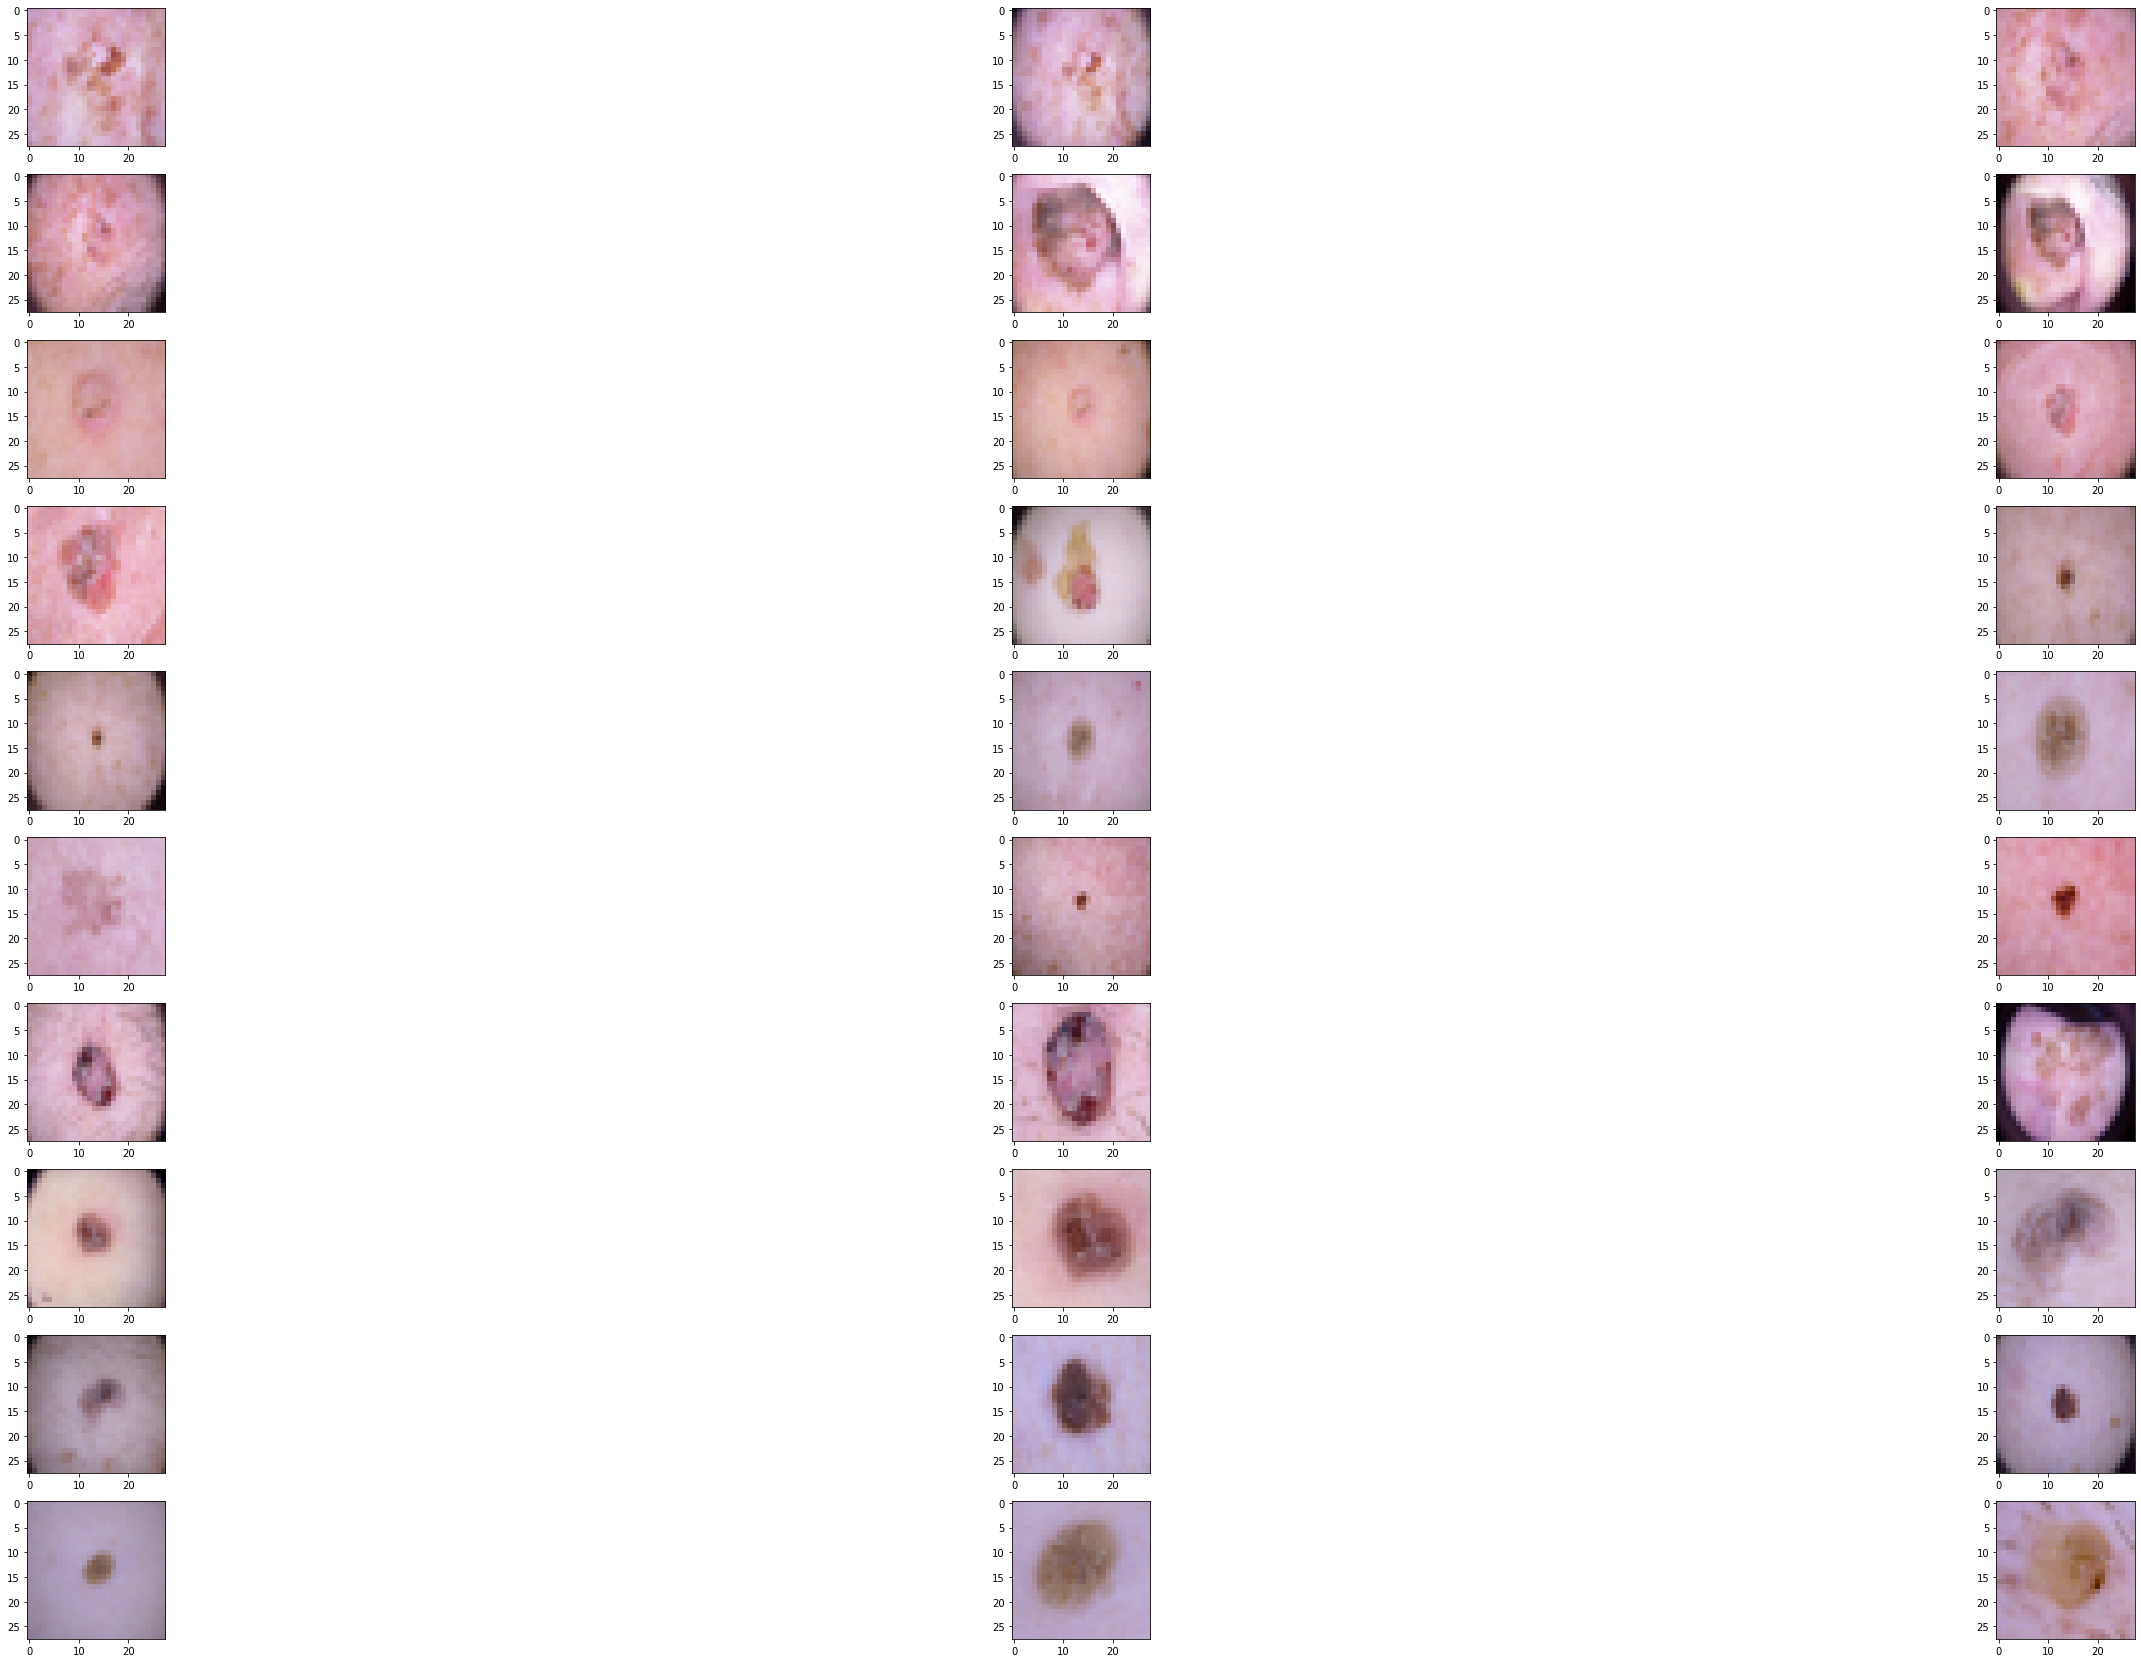

In [73]:
import matplotlib.pyplot as p
x=x.reshape(-1,28,28,3)
p.figure(figsize=(50,30))
for i in range(30):
    p.subplot(10,3,i+1)
    img=x[i]
    p.imshow(img)

In [74]:
trainx,trainy,testx,testy = train_test_split(x,y,test_size=0.05,random_state=42)

In [76]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator=ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')

In [78]:
im = data_generator.fit(trainx)

In [80]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
def accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [81]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop

model=Sequential()

model.add(Conv2D(64,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Conv2D(1024,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Conv2D(1024,(1,1),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(BatchNormalization())
#
model.add(Dropout(0.3))
model.add(Conv2D(1024,(1,1),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(BatchNormalization())



model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(7,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[accuracy])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 512)       131584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 512)        0         
 2D)                                                             
                                                        

In [82]:
#Reviewing our CNN model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 512)       131584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 512)        0         
 2D)                                                             
                                                        

In [84]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early=EarlyStopping(monitor='accuracy',patience=4,mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=2, verbose=1,cooldown=0, mode='auto',min_delta=0.0001, min_lr=0)

In [85]:
#Training our CNN
class_weights = {0:1,1:0.5,2:1,3:1,4:1,5:1,6:1}
model.fit(trainx,testx,epochs=50,batch_size=90,class_weight=class_weights,validation_data=(trainy, testy),callbacks=[early,reduce_lr])

Epoch 1/50
106/106 [==============================] - 10s 39ms/step - loss: 1.1101 - accuracy: 0.8021 - val_loss: 2.3829 - val_accuracy: 0.0978 - lr: 0.0010
Epoch 2/50
106/106 [==============================] - 3s 30ms/step - loss: 0.8097 - accuracy: 0.8400 - val_loss: 2.2825 - val_accuracy: 0.1617 - lr: 0.0010
Epoch 3/50
106/106 [==============================] - 3s 30ms/step - loss: 0.7300 - accuracy: 0.8562 - val_loss: 2.2970 - val_accuracy: 0.3094 - lr: 0.0010
Epoch 4/50
106/106 [==============================] - 3s 31ms/step - loss: 0.6914 - accuracy: 0.8738 - val_loss: 1.7076 - val_accuracy: 0.4152 - lr: 0.0010
Epoch 5/50
106/106 [==============================] - 3s 30ms/step - loss: 0.6812 - accuracy: 0.8726 - val_loss: 1.1635 - val_accuracy: 0.7345 - lr: 0.0010
Epoch 6/50
106/106 [==============================] - 3s 31ms/step - loss: 0.6672 - accuracy: 0.8779 - val_loss: 1.5000 - val_accuracy: 0.6607 - lr: 0.0010
Epoch 7/50
106/106 [==============================] - 3s 30ms/s

<AxesSubplot:>

<Figure size 1080x360 with 0 Axes>

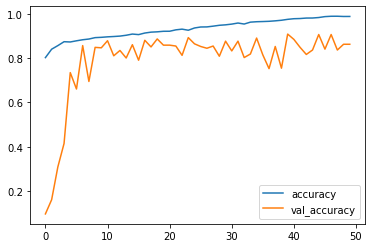

In [86]:
#Visualizing Training and Validation Accuracy
p.figure(figsize=(15,5))
loss=pd.DataFrame(model.history.history)
loss=loss[['accuracy','val_accuracy']]
loss.plot()

In [90]:
from sklearn.metrics import classification_report,confusion_matrix

predictions=model.predict_classes(trainy)

check=[]
for i in range(len(testy)):
  for j in range(7):
    if(testy[i][j]==1):
      check.append(j)
check=np.asarray(check)

print(classification_report(check,predictions))

AttributeError: 'Sequential' object has no attribute 'predict_classes'